# Analysis of Citibike trips by user demographics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read data
* trips

In [ ]:
DATA_DIR = "../data/"
YEARLY_TRIPS_DIR = DATA_DIR + "tripdata_parquet/NY/"
PARQUET_EXTENSION = ".parquet"
TRIPS_COLUMNS = [
    "tripduration",
    "starttime",
    "stoptime",
    "startstationid",
    "endstationid",
    "bikeid",
    "usertype",
    "birthyear",
    "gender",
]

In [ ]:
%%time
# read trips parquet, reset index, and drop dask column
trips = pd.read_parquet(
    YEARLY_TRIPS_DIR + "2019" + PARQUET_EXTENSION,
    columns=TRIPS_COLUMNS,
    engine="pyarrow",
).reset_index()
trips.drop(trips.columns[0], axis=1, inplace=True)  # drop the dask index

# manually change dtype of columns for trips df
trips["tripduration"] = trips["tripduration"].astype("int32")
trips["startstationid"] = trips["startstationid"].astype("int16")
trips["endstationid"] = trips["endstationid"].astype("int16")
trips["bikeid"] = trips["bikeid"].astype("int32")
trips["birthyear"] = trips["birthyear"].astype("int16")
trips["gender"] = trips["gender"].astype("int8")
trips["usertype"] = trips["usertype"].astype("category")
trips["starttime"] = pd.to_datetime(trips["starttime"])
trips["stoptime"] = pd.to_datetime(trips["stoptime"])

trips

CPU times: user 38.7 s, sys: 21.6 s, total: 1min
Wall time: 59.2 s


,tripduration,starttime,stoptime,startstationid,endstationid,bikeid,usertype,birthyear,gender
0,320,2019-01-01 00:01:47.401,2019-01-01 00:07:07.581,3160,3283,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.736,2019-01-01 00:10:00.608,519,518,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.997,2019-01-01 00:15:55.438,3171,3154,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.545,2019-01-01 00:52:22.650,504,3709,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.945,2019-01-01 00:12:39.502,229,503,35379,Subscriber,1979,1
...,...,...,...,...,...,...,...,...,...
20551512,729,2019-10-31 23:59:12.190,2019-11-01 00:11:21.486,237,311,25725,Subscriber,1995,1
20551513,645,2019-10-31 23:59:17.047,2019-11-01 00:10:02.945,3259,461,39583,Customer,1969,0
20551514,257,2019-10-31 23:59:22.514,2019-11-01 00:03:40.260,3798,505,21240,Subscriber,1985,1
20551515,466,2019-10-31 23:59:23.171,2019-11-01 00:07:09.205,328,361,34916,Subscriber,1989,0


## Helper Functions

In [ ]:
# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
def colors_from_values(values: pd.Series, palette_name: str, ascending=True):
    # convert to indices
    values = values.sort_values(ascending=ascending).reset_index()
    indices = values.sort_values(by=values.columns[0]).index
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

## Demographics EDA

In [ ]:
birthyears = (
    trips[["birthyear"]]
    .value_counts()
    .reset_index()
    .rename(columns={0: "countbirthyear"})
    .sort_values(by="birthyear", ascending=True)
)
birthyears

,birthyear,countbirthyear
109,1857,6
115,1863,2
110,1874,5
117,1880,1
84,1885,269
...,...,...
40,1999,161942
43,2000,124094
48,2001,62450
54,2002,27084


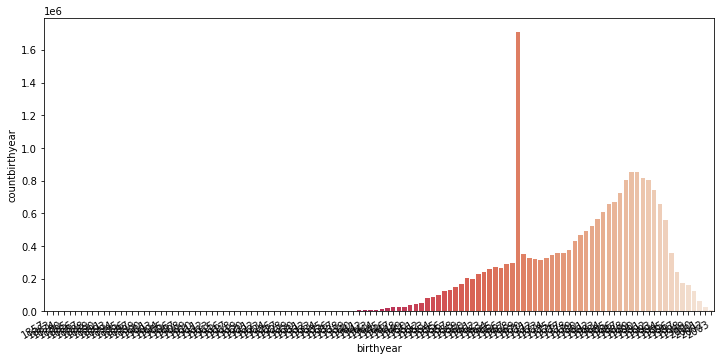

In [ ]:
# lot of 1969 births???
# sns.barplot(data=birthyears, x='birthyear', y='countbirthyear')
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
sns.barplot(
    data=birthyears,
    x="birthyear",
    y="countbirthyear",
    palette=colors_from_values(birthyears.countbirthyear, "rocket_r"),
)
fig.autofmt_xdate()
plt.show()

# Delete from memory. NOTE: Can verify it is gone with `who_ls`
del birthyears

In [ ]:
# by age. we see most riders are between 20 and 50 years
ages = trips[["birthyear", "gender"]]
ages["age"] = 2019 - ages["birthyear"]
age_bins = [0, 20, 30, 40, 50, 60, 70, 1000]
age_labels = ["<20", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"]
ages["agerange"] = pd.cut(
    ages.age, bins=age_bins, labels=age_labels, include_lowest=True
)

ageranges = (
    ages.drop("birthyear", axis=1)
    .groupby(["agerange", "gender"])
    .agg("sum")
    .reset_index()
    .rename(columns={"age": "count"})
)
ageranges["gender"] = ageranges["gender"].replace(
    {1: "male", 2: "female", 0: "unknown"}
)
ageranges = ageranges[ageranges["gender"] != "unknown"]

/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_43704/2524008272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages["age"] = 2019 - ages["birthyear"]
/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_43704/2524008272.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ages["agerange"] = pd.cut(


/opt/anaconda3/envs/python310/lib/python3.10/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


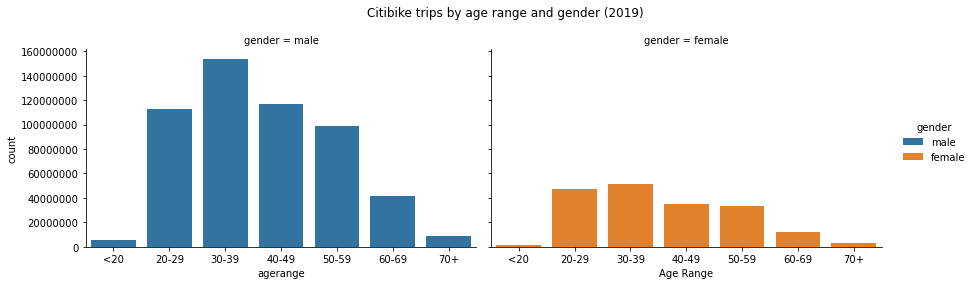

In [ ]:
# plot riders by age and gender
g = sns.FacetGrid(
    ageranges, col="gender", hue="gender", height=4, aspect=1.5, sharey=True
)
g.map(sns.barplot, "agerange", "count")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Citibike trips by age range and gender (2019)")
g.add_legend()
g.tight_layout()
plt.ticklabel_format(style="plain", axis="y")
plt.xlabel("Age Range")
plt.ylabel("Count")
plt.show()

# Remove from memory
del ages, ageranges, age_bins, age_labels

In [ ]:
# gender counts
genders = trips[["gender"]].value_counts().reset_index().rename(columns={0: "count"})
genders["gender"] = genders["gender"].replace({1: "Male", 2: "Female", 0: "Unknown"})
genders["percent"] = trips["gender"].value_counts(normalize=True).round(4).mul(100)
genders

,gender,count,percent
0,Male,14052230,7.59
1,Female,4938982,68.38
2,Unknown,1560305,24.03


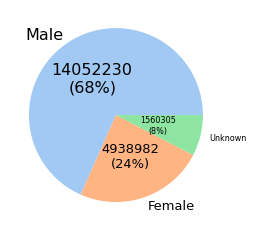

In [ ]:
# pie chart!
def autopct_format(values):
    def _(pct):
        total = sum(values)
        percent = int(round(pct * total / 100.0))
        return "{v:d}\n({:.0f}%)".format(pct, v=percent)

    return _


_, ax = plt.subplots()
_, labels, autopct = ax.pie(
    data=genders,
    x="count",
    labels="gender",
    colors=sns.color_palette("pastel"),
    autopct=autopct_format(genders["count"]),
    pctdistance=0.5,
)
autopct[0].set_fontsize(16)
autopct[1].set_fontsize(13)
autopct[2].set_fontsize(8)
labels[0].set_fontsize(16)
labels[1].set_fontsize(13)
labels[2].set_fontsize(8)

ax.set_aspect("equal")
plt.show()

# del genders